In [17]:
%load_ext autoreload
%autoreload 2
import os, sys

sys.path.append(
    os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ppi_py.datasets import load_dataset
from ppi_py import eff_ppi_logistic_ci_tuned
from tqdm import tqdm
from scipy.optimize import brentq
from scipy.special import expit
from scipy.stats import bernoulli
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
alpha = 0.1
ns = np.linspace(100, 1000, 4).astype(
    int
)  # Test for different numbers of labeled examples
N = 100000
num_trials = 5
d=2
coord = 0
sigmas = [0, 1e-6, 1e-3]

theta_star = np.zeros(d)
print(theta_star)

[0. 0.]


In [19]:
# Run prediction-powered inference and classical inference for many values of n
results = []
for s in range(len(sigmas)):
    sigma = sigmas[s]
    for j in tqdm(range(num_trials)):
        X = np.random.multivariate_normal(np.zeros(d), np.eye(d), ns.max())
        s = X@theta_star
        Y = bernoulli.rvs(expit(s))
        Yhat = expit(s + sigma*np.random.randn(ns.max()) )
        X_unlabeled = np.random.multivariate_normal(np.zeros(d), np.eye(d), N)
        s_unlabeled = X_unlabeled@theta_star
        Y_unlabeled = bernoulli.rvs(expit(s_unlabeled))
        Yhat_unlabeled = expit(s_unlabeled + sigma*np.random.randn(N))
        for i in range(ns.shape[0]):
            n = ns[i]
            _X = X[:n]
            _Y = Y[:n]
            _Yhat = Yhat[:n]

            # PPI interval
            ppi_ci_tuned = eff_ppi_logistic_ci_tuned(_X, _Y, _Yhat, X_unlabeled, Yhat_unlabeled, alpha=alpha, coord=coord, grad_tol=1e-2)
            ppi_ci = eff_ppi_logistic_ci_tuned(_X, _Y, _Yhat, X_unlabeled, Yhat_unlabeled, alpha=alpha, lhat=1, grad_tol=1e-2)
            classical_ci = eff_ppi_logistic_ci_tuned(_X, _Y, _Yhat, X_unlabeled, Yhat_unlabeled, alpha=alpha, lhat=0, grad_tol=1e-2)

            # Append results
            results += [
                pd.DataFrame(
                    [
                        {
                            "method": "PPI",
                            "n": n,
                            "lower": ppi_ci[0][coord],
                            "upper": ppi_ci[1][coord],
                            "included": (ppi_ci[0][coord] <= theta_star[coord]) & (ppi_ci[1][coord] >= theta_star[coord]),
                            "trial": j,
                            "sigma": sigma
                        }
                    ]
                )
            ]

            results += [
                pd.DataFrame(
                    [
                        {
                            "method": "classical",
                            "n": n,
                            "lower": classical_ci[0][coord],
                            "upper": classical_ci[1][coord],
                            "included": (classical_ci[0][coord] <= theta_star[coord]) & (classical_ci[1][coord] >= theta_star[coord]),
                            "trial": j,
                            "sigma": sigma
                        }
                    ]
                )
            ]

            results += [
                pd.DataFrame(
                    [
                        {
                            "method": "tuned PPI",
                            "n": n,
                            "lower": ppi_ci_tuned[0][coord],
                            "upper": ppi_ci_tuned[1][coord],
                            "included": (ppi_ci_tuned[0][coord] <= theta_star[coord]) & (ppi_ci_tuned[1][coord] >= theta_star[coord]),
                            "trial": j,
                            "sigma": sigma
                        }
                    ]
                )
            ]

df = pd.concat(results, axis=0, ignore_index=True)
df["width"] = df["upper"] - df["lower"]

  0%|                                                                                | 0/5 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [14]:
df[(df.method == "PPI") & (df.n == df.n.unique()[0]) * (df.sigma == sigmas[0])].width.mean()

0.7104163084734944

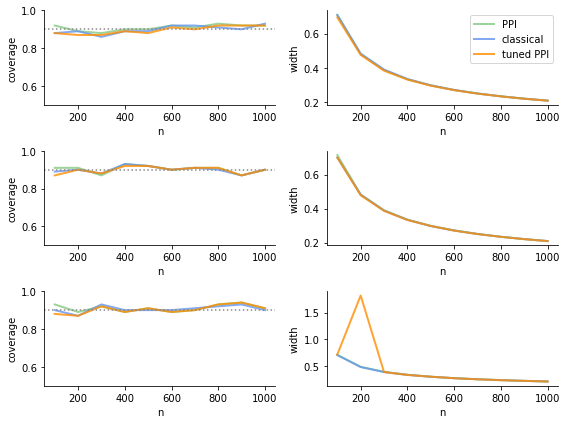

In [4]:
palette = {'tuned PPI' : 'darkorange',
           'PPI' : '#83C980',
           'classical' : 'cornflowerblue',
          }
df_plot = df[np.isin(df.method, list(palette.keys()))]
linewidth=2
n_unique_sigmas = df.sigma.nunique()

fig, axs = plt.subplots(nrows=n_unique_sigmas, ncols=2, figsize=(8,2*n_unique_sigmas))
for s in range(n_unique_sigmas): 
    cvg_ax = axs[s, 0]
    sz_ax = axs[s, 1]
    legend = False if s > 0 else True
    sns.lineplot(ax=cvg_ax, data=df_plot[df_plot.sigma == sigmas[s]], x="n", y="included", linewidth=linewidth, errorbar=None, hue="method", legend=False, palette=palette, alpha=0.8)
    sns.lineplot(ax=sz_ax, data=df_plot[df_plot.sigma == sigmas[s]], x="n", y="width", linewidth=linewidth, errorbar=None, hue="method", legend=legend, palette=palette, alpha=0.8)
    cvg_ax.set_ylabel("coverage")
    cvg_ax.set_ylim([0.5,1])
    cvg_ax.axhline(y=1-alpha, color="#888888", linestyle='dotted')
    if legend:
        sz_ax.legend_.set_title(None)
    
sns.despine(top=True, right=True)
plt.tight_layout()
os.makedirs('./plots',exist_ok=True)
plt.savefig('./plots/tuned-PPI-logistic.pdf')